In [1]:
%matplotlib inline
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import MaxPooling2D, Conv2D, Input, RepeatVector, Dropout
from keras.layers import Reshape, concatenate, Conv2DTranspose, UpSampling2D, Convolution2D
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from keras import optimizers, callbacks
from scipy import stats
import numpy as np
import keras
import cv2

from common import Metrics, plot_vessel, load_img

Using TensorFlow backend.


In [2]:
DATA_PATH = 'data/'
X_IMG_PATH = DATA_PATH + 'images/'
Y_IMG_PATH = DATA_PATH + 'labels/'

INPUT_SIZE = (512, 512)
ORIGINAL_SIZE = (700, 605)

POS_INPUT_THRESHOLD = .15
POS_OUTPUT_THRESHOLD = .45

In [3]:
def preprocess_train(filepath):
    img = load_img(filepath)
    img_resized = cv2.resize(img, INPUT_SIZE)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    img_yuv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2YUV)
    
    img_equ = cv2.equalizeHist(img_yuv[:,:,0])
    
    img = np.expand_dims(img_equ, axis=3).astype(np.float32)

    for i in range(len(img.shape)):  # Mean subtraction
        img[i] -= np.mean(img[i])
            
    return img

def preprocess_label(filepath):
    img = load_img(filepath)
    img = cv2.resize(img, INPUT_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = np.expand_dims(img, 3)
    img = (img / img.max()).astype(np.float32) > POS_INPUT_THRESHOLD
    return img

files = os.listdir(X_IMG_PATH)
original = [load_img(X_IMG_PATH + fname) for fname in files]
images_all = np.array([preprocess_train(X_IMG_PATH + fname) for fname in files])
labels_all = np.array([preprocess_label(Y_IMG_PATH + fname) for fname in files])

/home/mateusz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':
/home/mateusz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


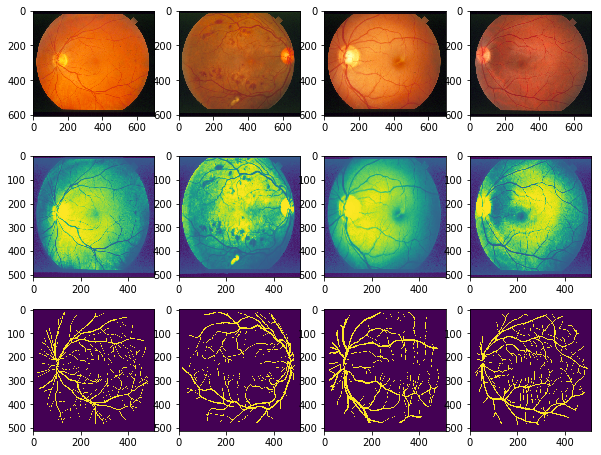

In [4]:
# Plot original images, images after preprocessing and ground truth mask
N_SHOW = 4  # How many examples should be shown
f, axarr = plt.subplots(3, N_SHOW, figsize=(10,8))

for i in range(N_SHOW):
    axarr[0, i].imshow(original[i])
    axarr[1, i].imshow(images_all[i,:,:,0])
    axarr[2, i].imshow(labels_all[i,:,:,0])

In [5]:
def get_model():
    """ Returns U-NET model
    
    Inspiration: https://github.com/zhixuhao/unet
    """
    input_img = Input((*INPUT_SIZE, 1), name='img')

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    optimizer = optimizers.Adam(lr=1e-5)
    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer='adam', metrics=['acc'], loss='binary_crossentropy')
    
    return model

In [6]:
get_model().summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  80          img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 8)  0           conv2d_2[0][0]                   
_____________________________________

In [7]:
kfold = KFold(n_splits=3)
y_true = [None] * labels_all.shape[0]
y_pred = [None] * labels_all.shape[0]

for train_index, test_index in kfold.split(images_all, labels_all):
    print('Training on new fold')
    X_train_local, X_test_local = images_all[train_index], images_all[test_index]
    y_train_local, y_test_local = labels_all[train_index], labels_all[test_index]
    
    es = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
    model = get_model()
    model.fit(X_train_local, y_train_local,
              batch_size=1, epochs=100,
              validation_data=(X_test_local, y_test_local),
              callbacks=[es], verbose=1)
    
    y_pred_local = model.predict(X_test_local)
    for i, index in enumerate(test_index):
        y_true[index] = y_test_local[i]
        y_pred[index] = y_pred_local[i]

Training on new fold
Instructions for updating:
Use tf.cast instead.
Train on 13 samples, validate on 7 samples
Epoch 1/100
13/13 [==============================] - 5s 354ms/step - loss: 2.7541 - acc: 0.5946 - val_loss: 0.6934 - val_acc: 0.8996
Epoch 2/100
13/13 [==============================] - 0s 33ms/step - loss: 0.5166 - acc: 0.9035 - val_loss: 0.4329 - val_acc: 0.8920
Epoch 3/100
13/13 [==============================] - 0s 34ms/step - loss: 0.4011 - acc: 0.8983 - val_loss: 0.4115 - val_acc: 0.8939
Epoch 4/100
13/13 [==============================] - 0s 35ms/step - loss: 0.3860 - acc: 0.9030 - val_loss: 0.4077 - val_acc: 0.8994
Epoch 5/100
13/13 [==============================] - 0s 35ms/step - loss: 0.3782 - acc: 0.9062 - val_loss: 0.3924 - val_acc: 0.9011
Epoch 6/100
13/13 [==============================] - 0s 33ms/step - loss: 0.3615 - acc: 0.9084 - val_loss: 0.3748 - val_acc: 0.9022
Epoch 7/100
13/13 [==============================] - 0s 37ms/step - loss: 0.3333 - acc: 0.9099 

13/13 [==============================] - 0s 35ms/step - loss: 0.1297 - acc: 0.9526 - val_loss: 0.1604 - val_acc: 0.9446
Epoch 61/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1241 - acc: 0.9543 - val_loss: 0.1594 - val_acc: 0.9436
Epoch 62/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1286 - acc: 0.9528 - val_loss: 0.1695 - val_acc: 0.9421
Epoch 63/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1275 - acc: 0.9529 - val_loss: 0.1631 - val_acc: 0.9443
Epoch 64/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1196 - acc: 0.9554 - val_loss: 0.1538 - val_acc: 0.9466
Epoch 65/100
13/13 [==============================] - 0s 36ms/step - loss: 0.1182 - acc: 0.9560 - val_loss: 0.1569 - val_acc: 0.9461
Epoch 66/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1173 - acc: 0.9570 - val_loss: 0.1470 - val_acc: 0.9468
Epoch 67/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1130 

13/13 [==============================] - 0s 35ms/step - loss: 0.1503 - acc: 0.9450 - val_loss: 0.1478 - val_acc: 0.9459
Epoch 45/100
13/13 [==============================] - 0s 36ms/step - loss: 0.1485 - acc: 0.9447 - val_loss: 0.1458 - val_acc: 0.9455
Epoch 46/100
13/13 [==============================] - 0s 34ms/step - loss: 0.1421 - acc: 0.9457 - val_loss: 0.1434 - val_acc: 0.9458
Epoch 47/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1381 - acc: 0.9479 - val_loss: 0.1387 - val_acc: 0.9483
Epoch 48/100
13/13 [==============================] - 0s 36ms/step - loss: 0.1354 - acc: 0.9480 - val_loss: 0.1411 - val_acc: 0.9466
Epoch 49/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1409 - acc: 0.9475 - val_loss: 0.1655 - val_acc: 0.9417
Epoch 50/100
13/13 [==============================] - 0s 34ms/step - loss: 0.1499 - acc: 0.9462 - val_loss: 0.1457 - val_acc: 0.9489
Epoch 51/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1445 

14/14 [==============================] - 0s 33ms/step - loss: 0.1668 - acc: 0.9415 - val_loss: 0.1585 - val_acc: 0.9449
Epoch 29/100
14/14 [==============================] - 0s 33ms/step - loss: 0.1664 - acc: 0.9403 - val_loss: 0.1456 - val_acc: 0.9473
Epoch 30/100
14/14 [==============================] - 0s 35ms/step - loss: 0.1569 - acc: 0.9425 - val_loss: 0.1431 - val_acc: 0.9477
Epoch 31/100
14/14 [==============================] - 1s 36ms/step - loss: 0.1520 - acc: 0.9446 - val_loss: 0.1477 - val_acc: 0.9463
Epoch 32/100
14/14 [==============================] - 0s 35ms/step - loss: 0.1562 - acc: 0.9441 - val_loss: 0.1443 - val_acc: 0.9474
Epoch 33/100
14/14 [==============================] - 0s 35ms/step - loss: 0.1489 - acc: 0.9448 - val_loss: 0.1490 - val_acc: 0.9461
Epoch 34/100
14/14 [==============================] - 0s 34ms/step - loss: 0.1710 - acc: 0.9410 - val_loss: 0.1489 - val_acc: 0.9469
Epoch 35/100
14/14 [==============================] - 0s 35ms/step - loss: 0.1555 

In [8]:
def process_predictions(y_pred):
    new_shape = (y_pred.shape[0], *INPUT_SIZE)
    y_proc = (np.reshape(y_pred, new_shape) * 255).astype(np.uint8)
    
    preds_bin = []
    for x in y_proc:
        img = cv2.resize(x, ORIGINAL_SIZE)
        pred_bin = img > POS_OUTPUT_THRESHOLD * 255
        preds_bin.append(pred_bin)
        
    return preds_bin

# Process ground truth samples and predictions
y_true_proc = process_predictions(np.array(y_true))
y_pred_proc = process_predictions(np.array(y_pred))

In [9]:
scores_all = []

for i, (y_true_sample, y_pred_sample) in enumerate(zip(y_true_proc, y_pred_proc)):
    scores = Metrics()
    scores.calculate(y_true_sample.ravel(), y_pred_sample.ravel())
    scores_all.append(scores)
    
    print(i, scores)

0 Acc: 0.94983, sensitivity: 0.71209, specificity: 0.97535, F1-score: 0.73346
1 Acc: 0.94030, sensitivity: 0.67540, specificity: 0.96992, F1-score: 0.69470
2 Acc: 0.95698, sensitivity: 0.71222, specificity: 0.98685, F1-score: 0.78265
3 Acc: 0.94659, sensitivity: 0.65238, specificity: 0.98439, F1-score: 0.73556
4 Acc: 0.93750, sensitivity: 0.41012, specificity: 0.98841, F1-score: 0.53604
5 Acc: 0.95149, sensitivity: 0.63339, specificity: 0.98123, F1-score: 0.69067
6 Acc: 0.94479, sensitivity: 0.59948, specificity: 0.98202, F1-score: 0.67881
7 Acc: 0.96489, sensitivity: 0.81794, specificity: 0.98001, F1-score: 0.81298
8 Acc: 0.96149, sensitivity: 0.79468, specificity: 0.97937, F1-score: 0.79983
9 Acc: 0.96837, sensitivity: 0.59678, specificity: 0.99303, F1-score: 0.70132
10 Acc: 0.95193, sensitivity: 0.75113, specificity: 0.97405, F1-score: 0.75613
11 Acc: 0.93941, sensitivity: 0.56221, specificity: 0.99114, F1-score: 0.69117
12 Acc: 0.94567, sensitivity: 0.63344, specificity: 0.98340, F

In [10]:
metrics_overview = Metrics.mean_metric(scores_all)
print('Mean metrics for {} samples:'.format(len(y_true)))
print(metrics_overview)

Mean metrics for 20 samples:
Acc: 0.94776, sensitivity: 0.58944, specificity: 0.98376, F1-score: 0.66215


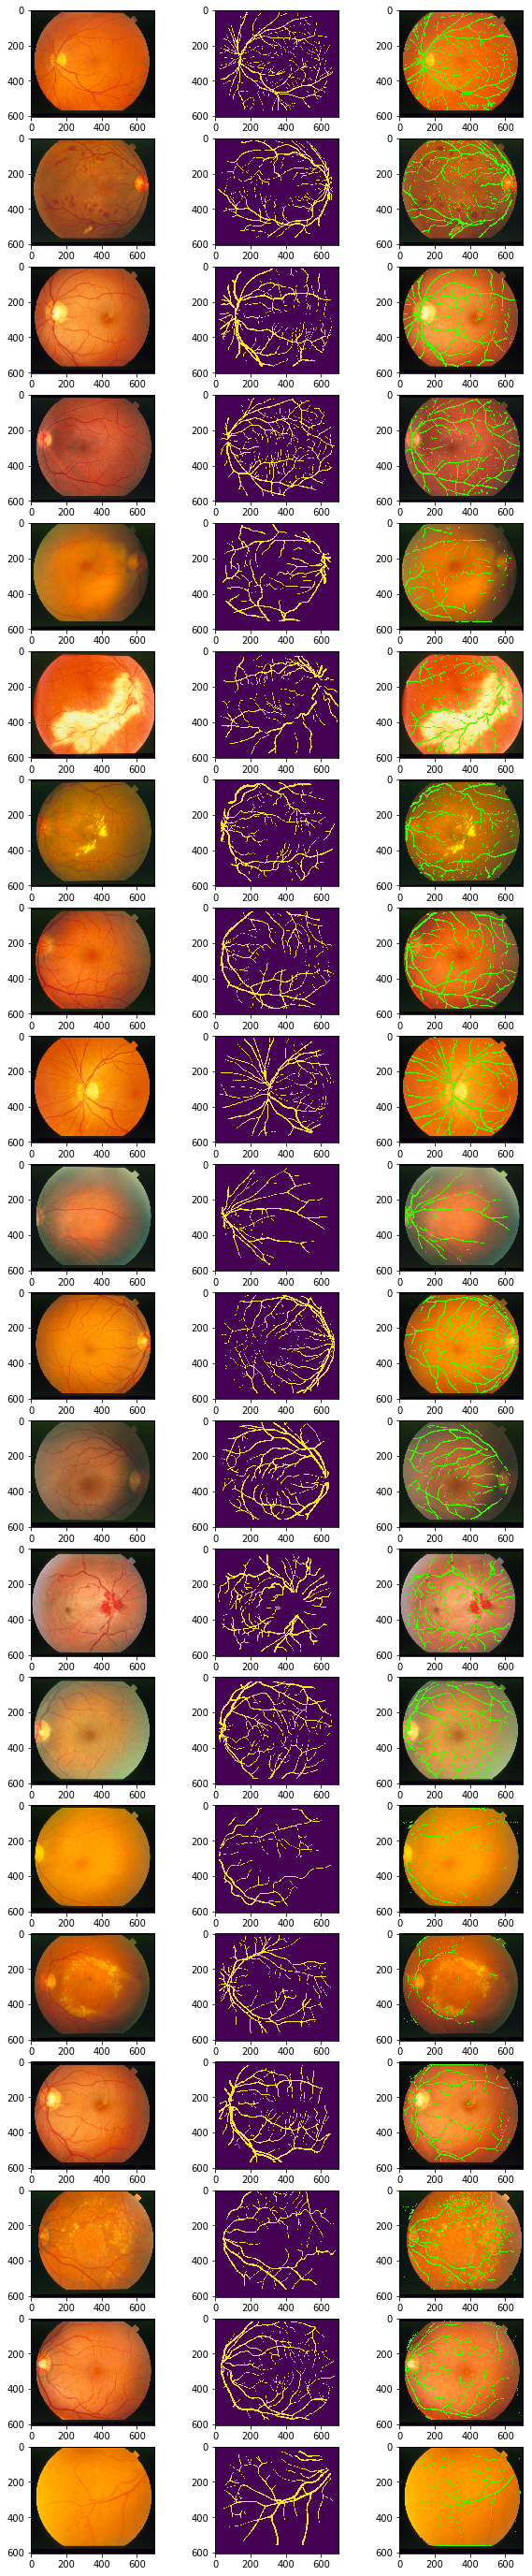

In [11]:
plot_vessel(original, y_true_proc, y_pred_proc, save_file='results.png')